# PPLM Style Guidance: Control Text Complexity

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

**Motivation**

Large scale language models are trained on diverse text with varying level of reading complexity. In this experiment, we want to understand if PPLM can be used to control the level of reading difficulty, i.e., if we can generate simple or complex text for a given topic. If this experiment is successful, we may be able to apply the PPLM approach for controlled language modeling (e.g., for translation/simplification).


**Experimental setup**
- Define a PPLM loss for simple vs. complex text.
   - Baseline: Top 1k/2k/5k English words from the Corpus of Contemporary American English ([COCA](https://www.wordfrequency.info)).
   - More involved: complexity discriminator trained on top of GPT-2. Need to get a corpus with annotated text complexity, or try to train a model to predict a readability index. Probably we have no time for this.
- Define a sufficient number of prompts.
- Generate texts for each prompt and evaluate complexity over this set of generated texts (see table below for the metrics).

**Evaluation**

We can score the generated samples on multiple dimensions:
- PPLM loss: a lower loss indicates that the sample is closer to the topic objective of PPLM.
- Perplexity: a proxy for fluency. Lower ppl = text is more fluent
- Dist-{1,2,3}: percentage of distinct n-grams. We average dist-{1,2,3}.
- Their readability
   - Flesch Reading Ease
   - Gunning-Fog index
   - Automated Readability Index (ARI)
   - Coleman-Liau Index
- Statistics
   - Number of words and syllables
   - Number of sentences
   - % of used words that are present in simple BoW ("simple word precision")

All metrics/statistics with std. and a density plot to see the spread in values.

**Prompt Design**

We aim to generate definitions for complicated concepts. A human would be able to explain each of these concepts in simple terms. Can a language model do the same?

In [12]:
from run_pplm_simple_text import TRAIN_PROMPTS, TEST_PROMPTS, PROMPTS
from pprint import pprint

print('Training prompts:')
pprint(TRAIN_PROMPTS)

print('\nTest prompts:')
pprint(TEST_PROMPTS)

Training prompts:
['The steam engine is', 'The ozone layer is', 'A fracture is', 'The potato']

Test prompts:
['Vitamine D is',
 'Machine learning is',
 'Convex optimization is',
 'Electricity is',
 'A car is',
 'Gravity is',
 'Rain is',
 'A radiograph is',
 'A pulmonary edema is',
 'A rope is',
 'The football',
 'The chicken',
 'The horse',
 'The pizza',
 'The lake',
 'The house',
 'The train',
 'The plain',
 'The tunnel',
 'The mountains',
 'The French country']


## Notebook setup

### Imports

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()

plt.style.use('seaborn-talk')

In [14]:
import math
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import (GPT2Tokenizer, OpenAIGPTLMHeadModel,
                          OpenAIGPTTokenizer)
from transformers.modeling_gpt2 import GPT2LMHeadModel

from dist import eval_distinct
from run_pplm import run_pplm_example
from run_pplm_simple_text import postprocess_pplm_output, pplm_loss

from IPython.display import display, HTML

In [15]:
PPLM_TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2-medium")

In [16]:
import warnings
# Surpress transformers/modeling_gpt2.py:757: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reproduce PPLM examples

Default set of hyperparameters does not result in any on-topic words. From the PPLM readme: 

> Tuning hyperparameters for bag-of-words control
>
> 1. Increase `--stepsize` to intensify topic control, and decrease its value to soften the control. `--stepsize 0` recovers the original uncontrolled GPT-2 model. 
> 
> 2. If the language being generated is repetitive (For e.g. "science science experiment experiment"), there are several options to consider: </br>
> 	a) Reduce the `--stepsize` </br>
> 	b) Increase `--kl_scale` (the KL-loss coefficient) or decrease `--gm_scale` (the gm-scaling term) </br>
> 	c) Add `--grad-length xx` where xx is an (integer <= length, e.g. `--grad-length 30`).</br>



Increasing the step size helps, but we get degenerated text with a repetition. Regularizing with post norm geometric mean fusion seems to work. We get some words which are on topic for military, while generating somewhat fluent text.

In [7]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="The potato",
    num_samples=5,
    bag_of_words='military',
    length=25,
    stepsize=0.06,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.01,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>The potato

= Unperturbed generated text =
<|endoftext|>The potato plant is a member of the cabbage family, but is also a member of the mustard family, and is sometimes confused with mustard

= Perturbed generated text 1 =
<|endoftext|>The potato is one that I always eat as a snack when I'm hungry. This potato is a bomb. I've been trying to

= Perturbed generated text 2 =
<|endoftext|>The potato was the first to fall, but the potato salad has since taken over.

The world may be on a nuclear war

= Perturbed generated text 3 =
<|endoftext|>The potato salad revolution may have come to America but the food war continues in the Middle East

"I'm not a terrorist,"

= Perturbed generated text 4 =
<|endoftext|>The potato chip is the most popular chip snack in Canada, but is it the healthiest?

We asked the experts to weigh

= Perturbed generated text 5 =
<|endoftext|>The potato is a member of the class of food that's never been invented. That's what they sa

Print resulting data structures.

In [33]:
print('loss_in_time shape = (num_samples, length, num_iterations)')
print(f'loss_in_time.shape = ({len(losses_in_time)}, {len(losses_in_time[0])}, {len(losses_in_time[0][0])})')

print('\nGenerated unperturbed tokens:')
print(unpert_gen_tok_text)
print(repr(PPLM_TOKENIZER.decode(unpert_gen_tok_text[0])))

print('\nGenerated perturbed tokens:')
print(pert_gen_tok_texts)

print('\nGenerated text:')
for text in pert_gen_tok_texts:
    text_decoded = PPLM_TOKENIZER.decode(text.tolist()[0])
    print('-', repr(text_decoded))

print('\nDiscrimnator loss (should be empty, as we use BoW loss):')
print(discrim_losses)

loss_in_time shape = (num_samples, length, num_iterations)
loss_in_time.shape = (5, 25, 3)

Generated unperturbed tokens:
tensor([[50256,   464, 21219,  4618,   318,   257,  2888,   286,   262, 41266,
          1641,    11,   475,   318,   635,   257,  2888,   286,   262, 33694,
          1641,    11,   290,   318,  3360, 10416,   351, 33694]],
       device='cuda:0')
'<|endoftext|>The potato plant is a member of the cabbage family, but is also a member of the mustard family, and is sometimes confused with mustard'

Generated perturbed tokens:
[tensor([[50256,   464, 21219,   318,   530,   326,   314,  1464,  4483,   355,
           257, 26906,   618,   314,  1101, 14720,    13,   770, 21219,   318,
           257,  5194,    13,   314,  1053,   587,  2111,   284]],
       device='cuda:0'), tensor([[50256,   464, 21219,   373,   262,   717,   284,  2121,    11,   475,
           262, 21219, 20698,   468,  1201,  2077,   625,    13,   198,   198,
           464,   995,   743,   307,   31

## Evaluation

### PPLM loss

In [34]:
pplm_loss(losses_in_time)

[100.9444808959961,
 105.42831420898438,
 143.51016235351562,
 81.40776824951172,
 89.2205810546875]

### Distinct n-grams

Toy example for distinct-{1,2,3}

In [17]:
print('dist-{1,2,3} =', eval_distinct(['This is a test.'], PPLM_TOKENIZER))

dist-{1,2,3} = (1.0, 0.8, 0.6)


### Perplexity

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def compute_ppl(sent):
    indexed_tokens = ppl_tokenizer.encode(sent)
    tokens_tensor = torch.tensor([indexed_tokens])
    tokens_tensor = tokens_tensor.to(device)
    with torch.no_grad():
        outputs = ppl_model.forward(tokens_tensor, labels=tokens_tensor)
    loss = outputs[0]
    return math.exp(loss.item())



ppl_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
ppl_model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
ppl_model.to(device)
_ = ppl_model.eval()

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
sents = [
    'there is a book on the desk',
    'there is a plane on the desk',
    'there is a book in the desk',
]

for sent in sents:
    print(f'PPL: {compute_ppl(sent):.2f} - {sent}')

PPL: 21.32 - there is a book on the desk
PPL: 61.46 - there is a plane on the desk
PPL: 26.25 - there is a book in the desk


### Readability

In [20]:
import textstat

In [21]:
test_data = (
    "Playing games has always been thought to be important to "
    "the development of well-balanced and creative children; "
    "however, what part, if any, they should play in the lives "
    "of adults has never been researched that deeply. I believe "
    "that playing games is every bit as important for adults "
    "as for children. Not only is taking time out to play games "
    "with our children and other adults valuable to building "
    "interpersonal relationships but is also a wonderful way "
    "to release built up tension."
)

In [22]:
rows = (
    ('Flesch Reading Ease', textstat.flesch_reading_ease(test_data)),
    ('Gunning Fog', textstat.gunning_fog(test_data)),
    ('Coleman Liau', textstat.coleman_liau_index(test_data)),
    ('ARI', textstat.automated_readability_index(test_data)),
    ('Lexicon Count', textstat.lexicon_count(test_data)),
    ('Syllable Count', textstat.syllable_count(test_data)),
    ('Sentence Count', textstat.sentence_count(test_data)),
)

for key, value in rows:
    print(f'{key:<20} = {value}')

Flesch Reading Ease  = 52.23
Gunning Fog          = 12.38
Coleman Liau         = 11.03
ARI                  = 15.5
Lexicon Count        = 82
Syllable Count       = 121
Sentence Count       = 3


### Percentage of words that occur in wordlist

In [23]:
from nltk import word_tokenize
import string

In [24]:
with open('paper_code/wordlists/english-1k.txt') as fin:
    english_1k = [line.strip() for line in fin.readlines()]

with open('paper_code/wordlists/english-2k.txt') as fin:
    english_2k = [line.strip() for line in fin.readlines()]

with open('paper_code/wordlists/english-5k.txt') as fin:
    english_5k = [line.strip() for line in fin.readlines()]
    
    
def simple_word_precision(wordlist):
    wordlist = set(wordlist)
    
    def measure(text):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if not t.isdigit() and not t in string.punctuation]
        
        total = len(tokens)
        hit = sum(1 for token in tokens if token in wordlist)
        
        return hit / total
    
    return measure

precision_english_1k = simple_word_precision(english_1k)
precision_english_2k = simple_word_precision(english_2k)
precision_english_5k = simple_word_precision(english_5k)

In [25]:
print(precision_english_1k('this is remarkable'))
print(precision_english_5k('this is remarkable'))
print(precision_english_1k('this is a test 123 .'))

0.6666666666666666
1.0
1.0


### Evaluate batch

In [26]:
import re

def clean_text(t):
    t = t.replace('<|endoftext|>', '')
    t = re.sub('\s{1,}', ' ', t)
    return t


def evaluate(samples: List[str]):
    df = pd.DataFrame({
        'text': [clean_text(sample) for sample in samples]
    })
    df['ppl'] = df['text'].apply(compute_ppl)
    dist = df['text'].apply(lambda text: eval_distinct([text], PPLM_TOKENIZER))
    df[['dist-1', 'dist-2', 'dist-3']] = pd.DataFrame(dist.tolist())
    df['dist'] = dist.apply(np.mean)
    
    # Readability metrics
    df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)
    df['gunning_fog'] = df['text'].apply(textstat.gunning_fog)
    df['automated_readability_index'] = df['text'].apply(textstat.automated_readability_index)
    df['coleman_liau_index'] = df['text'].apply(textstat.coleman_liau_index)
    df['lexicon_count'] = df['text'].apply(textstat.lexicon_count)
    df['syllable_count'] = df['text'].apply(textstat.syllable_count)
    df['sentence_count'] = df['text'].apply(textstat.sentence_count)
    df['precision_english_1k'] = df['text'].apply(precision_english_1k)
    df['precision_english_2k'] = df['text'].apply(precision_english_2k)
    df['precision_english_5k'] = df['text'].apply(precision_english_5k)
    
    return df

### Example for one batch of generated samples

Lets evaluate the 5 samples we generated above according to the metrics. Observations:
- Many instances would be discarded by `dist >= 0.85`.
- Instances with lower loss have some degree on repetition. I can just repeat the word `bomb` and will get a low loss because it's part of the BoW.
- By Flesch Reading Ease, all generated examples are already easier to read than the unperturbed example, although we haven't yet implemented a complexity loss into PPLM. Do we need an additional baseline?

In [35]:
df_output = postprocess_pplm_output(
    unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time, PPLM_TOKENIZER
)
df_output = pd.concat([
    df_output,
    evaluate(df_output['raw'])
], axis=1)
df_output

,raw,kind,pplm_loss,text,ppl,dist-1,dist-2,dist-3,dist,flesch_reading_ease,gunning_fog,automated_readability_index,coleman_liau_index,lexicon_count,syllable_count,sentence_count,precision_english_1k,precision_english_2k,precision_english_5k
0,<|endoftext|>The potato plant is a member of t...,unperturbed,NaN,The potato plant is a member of the cabbage fa...,43.785672,0.666667,0.814815,0.851852,0.777778,54.56,10.00,11.8,8.07,25,38,1,0.72000,0.760000,0.800000
1,<|endoftext|>The potato is one that I always e...,perturbed,100.944481,The potato is one that I always eat as a snack...,41.500872,0.777778,0.925926,0.925926,0.876543,97.50,3.08,-0.5,0.54,23,28,3,0.52000,0.520000,0.600000
2,"<|endoftext|>The potato was the first to fall,...",perturbed,105.428314,"The potato was the first to fall, but the pota...",84.848064,0.920000,0.960000,0.920000,0.933333,85.18,6.34,2.4,3.23,23,29,2,0.73913,0.782609,0.826087
3,<|endoftext|>The potato salad revolution may h...,perturbed,143.510162,The potato salad revolution may have come to A...,97.506482,0.960000,0.960000,0.920000,0.946667,57.61,14.25,11.0,8.01,22,34,1,0.48000,0.520000,0.640000
4,<|endoftext|>The potato chip is the most popul...,perturbed,81.407768,The potato chip is the most popular chip snack...,79.286990,0.840000,0.960000,0.920000,0.906667,85.69,8.04,3.8,5.26,22,29,2,0.50000,0.590909,0.681818
5,<|endoftext|>The potato is a member of the cla...,perturbed,89.220581,The potato is a member of the class of food th...,37.777110,0.740741,0.851852,0.851852,0.814815,97.91,4.74,1.7,2.73,22,27,3,0.68000,0.680000,0.680000


## Generating simple texts with PPLM-BoW loss

Observations:
- PPLM is really "brittle." Slight changes in hyperparameters completely alter the text.
- Unperturbed text seem more logical than the perturbed variants. 
- Casing problem: when we increase the step size, all words become lowercase. This is because the wordlist only includes lowercase word forms. One quick fix might be to also add the capitalized terms. However, then we might get the problem that capital words also appear mid-sentence.

### The steam engine is...

In [9]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="The steam engine is",
    num_samples=5,
    bag_of_words='english-1k',
    length=50,
    stepsize=0.08,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.01,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>The steam engine is

= Unperturbed generated text =
<|endoftext|>The steam engine is a steam engine of the type used for making gas, but with a much higher efficiency. It's also very efficient compared to other types that have to be built with steam or coal, such as the steam engine that powered the steam locomotive.


= Perturbed generated text 1 =
<|endoftext|>The steam engine is the most important part of the modern car and one of the most important and powerful in the world. The car has a range of about 1-10 km and can move in a very smooth and easy and very fast way, the most important thing is

= Perturbed generated text 2 =
<|endoftext|>The steam engine is a type of steam-generating machine in the general type of the power, industrial and transportation use of the type that is a type of power, industrial and transportation use of the type.

the use of a particular type of electricity to power

= Perturbed generated text 3 =
<|endoftext|>The st

Lets try to generate slightly longer texts. We get some long-winded and repetitive phrases like `is the most important and important` and `in the general type of the power, industrial and transportation use of the type that is a type of power`

In [21]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="The steam engine is",
    num_samples=5,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.08,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.01,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>The steam engine is

= Unperturbed generated text =
<|endoftext|>The steam engine is a steam engine of the type used for making gas, but with a much higher efficiency. It's also very efficient compared to other types that have to be built with steam or coal, such as the steam engine that powered the steam locomotive.

The steam generator is a boiler or gas turbine used to power a steam engine, although it may be much faster.

It also has a much higher efficiency than the coal generator, and is used to heat the fuel, as well as powering

= Perturbed generated text 1 =
<|endoftext|>The steam engine is a type of steam-generating machine in the general type of the power, industrial and transportation use of the type that is a type of power, industrial and transportation use of the type.

the use of a particular type of electricity to power a type of power, industrial or transportation use of the type.<|endoftext|>This article first appeared in the April 

What happens when we increase the kl scale?

In [22]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="The steam engine is",
    num_samples=5,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.08,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.1,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>The steam engine is

= Unperturbed generated text =
<|endoftext|>The steam engine is a steam engine of the type used for making gas, but with a much higher efficiency. It's also very efficient compared to other types that have to be built with steam or coal, such as the steam engine that powered the steam locomotive.

The steam generator is a boiler or gas turbine used to power a steam engine, although it may be much faster.

It also has a much higher efficiency than the coal generator, and is used to heat the fuel, as well as powering

= Perturbed generated text 1 =
<|endoftext|>The steam engine is one of the most important parts of any car, but not every car has it in it's own right. Some cars have it in the car but have it in a more specific way. The car that have the most important part in it's engine is the car that has a steam engine in it. The steam engine in most of the cars of the world is very similar to the one that you are thinking of hav

The results look somewhat reasonable. Let's try the settings for a slightly different prompt.

In [23]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="How does the steam engine work?",
    num_samples=3,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.08,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.1,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>How does the steam engine work?

= Unperturbed generated text =
<|endoftext|>How does the steam engine work? How is it used? And why?

The steam engine is basically a giant, high-pressure engine which powers a large amount of steam. It is made of steel.

The steam engine works by using electricity to turn steam from a very small, very hot liquid into a very, very hot solid. The electric power used by the steam works by using two coils in the steam generator's shaft to move the steam up a hill or up to a very small, very hot liquid.

= Perturbed generated text 1 =
<|endoftext|>How does the steam engine work?

How do you heat up water in the bottom of the boiler?

What is the difference between a boiler and a steam engine?

What is a gas stove or gas fire?

How many people use gas heat to heat food, and what are their safety concerns?

What is the difference between a hot tub and a steam boiler?

What is a steam engine?

How many people are using elect

When we increase the step size, all sentence start words become lowercase. This is likely because the wordlist only includes lowercase word forms.

In [24]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="How does the steam engine work?",
    num_samples=3,
    bag_of_words='english-1k',
    length=50,
    stepsize=0.2,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.01,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>How does the steam engine work?

= Unperturbed generated text =
<|endoftext|>How does the steam engine work? How is it used? And why?

The steam engine is basically a giant, high-pressure engine which powers a large amount of steam. It is made of steel.

The steam engine works by using electricity to turn steam from a

= Perturbed generated text 1 =
<|endoftext|>How does the steam engine work?

 the steam is the main source of power for the steam engine and all other parts of the ship. and it is a huge part of the overall weight of the ship. and the amount of power is not the only reason for the weight and

= Perturbed generated text 2 =
<|endoftext|>How does the steam engine work?
How did steam go from its original form of use and use as the primary means of transportation to now the only method of transport?
 and is that why they call it the 'old man in a suit' now? the old man is now

= Perturbed generated text 3 =
<|endoftext|>How does the steam 

### Machine learning is...

In [25]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="Machine learning is",
    num_samples=5,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.08,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.1,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>Machine learning is

= Unperturbed generated text =
<|endoftext|>Machine learning is a method of applying mathematical ideas to solve practical problems, with particular emphasis on artificial intelligence.

In this section I'm going to introduce you to machine learning with a simple example, a text that you would find in any computer science class.

The problem is that, when we type 'hello world', the text that gets displayed appears.

This is not a bad thing; you could have typed in the correct answer and the text would have appeared. It is just that the output

= Perturbed generated text 1 =
<|endoftext|>Machine learning is a technique that can make your computer more efficient at its tasks.

It can be applied to any type of problem where there is an objective and you need to be sure that the results of your work have value. Machine learning can also be used to analyze and improve any data you collect. There are many tools for this kind of tasks, 

The perturbed examples are not too fluent. Decrease `stepsize`.

In [26]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="Machine learning is",
    num_samples=5,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.04,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.1,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>Machine learning is

= Unperturbed generated text =
<|endoftext|>Machine learning is a method of applying mathematical ideas to solve practical problems, with particular emphasis on artificial intelligence.

In this section I'm going to introduce you to machine learning with a simple example, a text that you would find in any computer science class.

The problem is that, when we type 'hello world', the text that gets displayed appears.

This is not a bad thing; you could have typed in the correct answer and the text would have appeared. It is just that the output

= Perturbed generated text 1 =
<|endoftext|>Machine learning is a technique that can make your computer more efficient at its tasks.

But sometimes it can make you more expensive to run and maintain. This is because you can't always predict the results of your work.

To make things more simple, it is a good idea to have an idea of the cost of running your machine and how expensive it is to 

### The ozone layer is....

In [27]:
unpert_gen_tok_text, pert_gen_tok_texts, discrim_losses, losses_in_time = run_pplm_example(
    cond_text="The ozone layer is",
    num_samples=5,
    bag_of_words='english-1k',
    length=100,
    stepsize=0.04,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.65,
    kl_scale=0.1,
    verbosity='quiet',
    colorama=True
)

= Prefix of sentence =
<|endoftext|>The ozone layer is

= Unperturbed generated text =
<|endoftext|>The ozone layer is a global protection shield, protecting us from harmful cosmic rays. But as the ozone layer continues to decline and as the planet warms, we are seeing a growing number of scientists arguing that the ozone layer isn't protecting us from harmful cosmic rays.

The scientific consensus is that the ozone layer is protecting us from harmful cosmic rays, but there are many ways that it is failing at its job.

The ozone layer protects us from the radiation of our stars. It is not the primary protective

= Perturbed generated text 1 =
<|endoftext|>The ozone layer is a layer that protects the planet from the sun, while other layers protect the air around us from the sun and other pollutants. When the air around you is dirty, you are getting the sun's light into your home and your home is getting the sun's light into your air. When that happens, the air around you is not as hot a

## Generate samples

Generate samples for all prompts and write to CSV file for further analysis.

```sh
conda activate pplm
mkdir -p data/

python run_pplm_simple_text.py --bag_of_words english-1k --out_file data/english-1k.csv
python run_pplm_simple_text.py --bag_of_words english-2k --out_file data/english-2k.csv
python run_pplm_simple_text.py --bag_of_words english-5k --out_file data/english-5k.csv
```

## Analysis of generated samples

In [27]:
# Load raw data
df_english_1k = pd.read_csv('data/english-1k.csv', index_col=0)
df_english_2k = pd.read_csv('data/english-2k.csv', index_col=0)
df_english_5k = pd.read_csv('data/english-5k.csv', index_col=0)

# Compute metrics
df_english_1k = pd.concat([df_english_1k, evaluate(df_english_1k['raw'])], axis=1)
df_english_2k = pd.concat([df_english_2k, evaluate(df_english_2k['raw'])], axis=1)
df_english_5k = pd.concat([df_english_5k, evaluate(df_english_5k['raw'])], axis=1)

# Split unperturbed/perturbed samples
unperturbed = df_english_1k[df_english_1k['kind'] == 'unperturbed'].copy()
df_english_1k = df_english_1k[df_english_1k['kind'] == 'perturbed'].copy()
df_english_2k = df_english_2k[df_english_2k['kind'] == 'perturbed'].copy()
df_english_5k = df_english_5k[df_english_5k['kind'] == 'perturbed'].copy()

unperturbed['PPLM objective'] = 'unperturbed'
df_english_1k['PPLM objective'] = 'BoW English 1K'
df_english_2k['PPLM objective'] = 'BoW English 2K'
df_english_5k['PPLM objective'] = 'BoW English 5K'

For each prompt we generated 5 samples with different random seeds. Following the PPLM paper, we select the final text by 1) filtering samples with high repetition (`dist >= 0.8`), and then picking the candidate with _lowest_ PPLM loss. Note that the PPLM loss is lowest when the probability mass is only distributed to tokens in the bag-of-words. So we can use it as a proxy for text complexity.

In [28]:
def get_best(df):
    candidates = df[(df['kind'] == 'perturbed') & (df['dist'] >= 0.8)]
    top_ixs = candidates.groupby('prompt')['pplm_loss'].idxmin()
    return df.loc[top_ixs]


df_1k_top = get_best(df_english_1k)
df_2k_top = get_best(df_english_2k)
df_5k_top = get_best(df_english_5k)

assert df_1k_top['prompt'].nunique() == len(PROMPTS)
assert df_2k_top['prompt'].nunique() == len(PROMPTS)
assert df_5k_top['prompt'].nunique() == len(PROMPTS)

Average all metrics grouped by wordlist.

In [29]:
METRICS = [
    'ppl',
    'dist',
    'flesch_reading_ease',
    'gunning_fog',
    'automated_readability_index',
    'coleman_liau_index',
    'lexicon_count',
    'syllable_count', 
    'sentence_count',
    'precision_english_1k',
    'precision_english_2k',
    'precision_english_5k',
]


df_combined = pd.concat([
    unperturbed,
    df_1k_top,
    df_2k_top,
    df_5k_top
], ignore_index=True)

df_agg = df_combined[METRICS + ['PPLM objective']].groupby('PPLM objective').agg('mean')
df_agg.head()

,ppl,dist,flesch_reading_ease,gunning_fog,automated_readability_index,coleman_liau_index,lexicon_count,syllable_count,sentence_count,precision_english_1k,precision_english_2k,precision_english_5k
PPLM objective,,,,,,,,,,,,
BoW English 1K,23.757891,0.835676,70.7796,11.7484,10.276,6.0572,91.68,119.20,4.04,0.790416,0.839639,0.882968
BoW English 2K,29.629796,0.842021,70.5572,11.9888,10.420,6.4048,90.16,118.68,4.04,0.764528,0.835402,0.876271
BoW English 5K,26.047115,0.836803,70.0728,11.9520,10.848,6.6728,93.24,122.48,3.92,0.757374,0.821432,0.891493
unperturbed,33.175823,0.822977,68.9980,10.5564,9.820,7.5976,80.96,112.08,4.60,0.606582,0.678349,0.758236


### Descriptive statistics

Number of words (`lexicon_count`):

- Samples generated with PPLM are on average longer than unperturbed samples in the number of words.
- This is because of the underlying Byte-Pair Encoding (BPE). During generation we've set the maximum sample length to 100 _tokens_. However, since a word may consist of multiple tokens in BPE, the number of words is _at most_ the number of tokens.
- As we see that PPLM samples consist of more words, we can infer that more common words are sampled (i.e., words which do _not_ have a subword representation).

There are no significant observations for the other descriptive statistics (number of sentences, number of syllables).

,lexicon_count,sentence_count,syllable_count
PPLM objective,,,
unperturbed,80.96,4.60,112.08
BoW English 1K,91.68,4.04,119.20
BoW English 2K,90.16,4.04,118.68
BoW English 5K,93.24,3.92,122.48


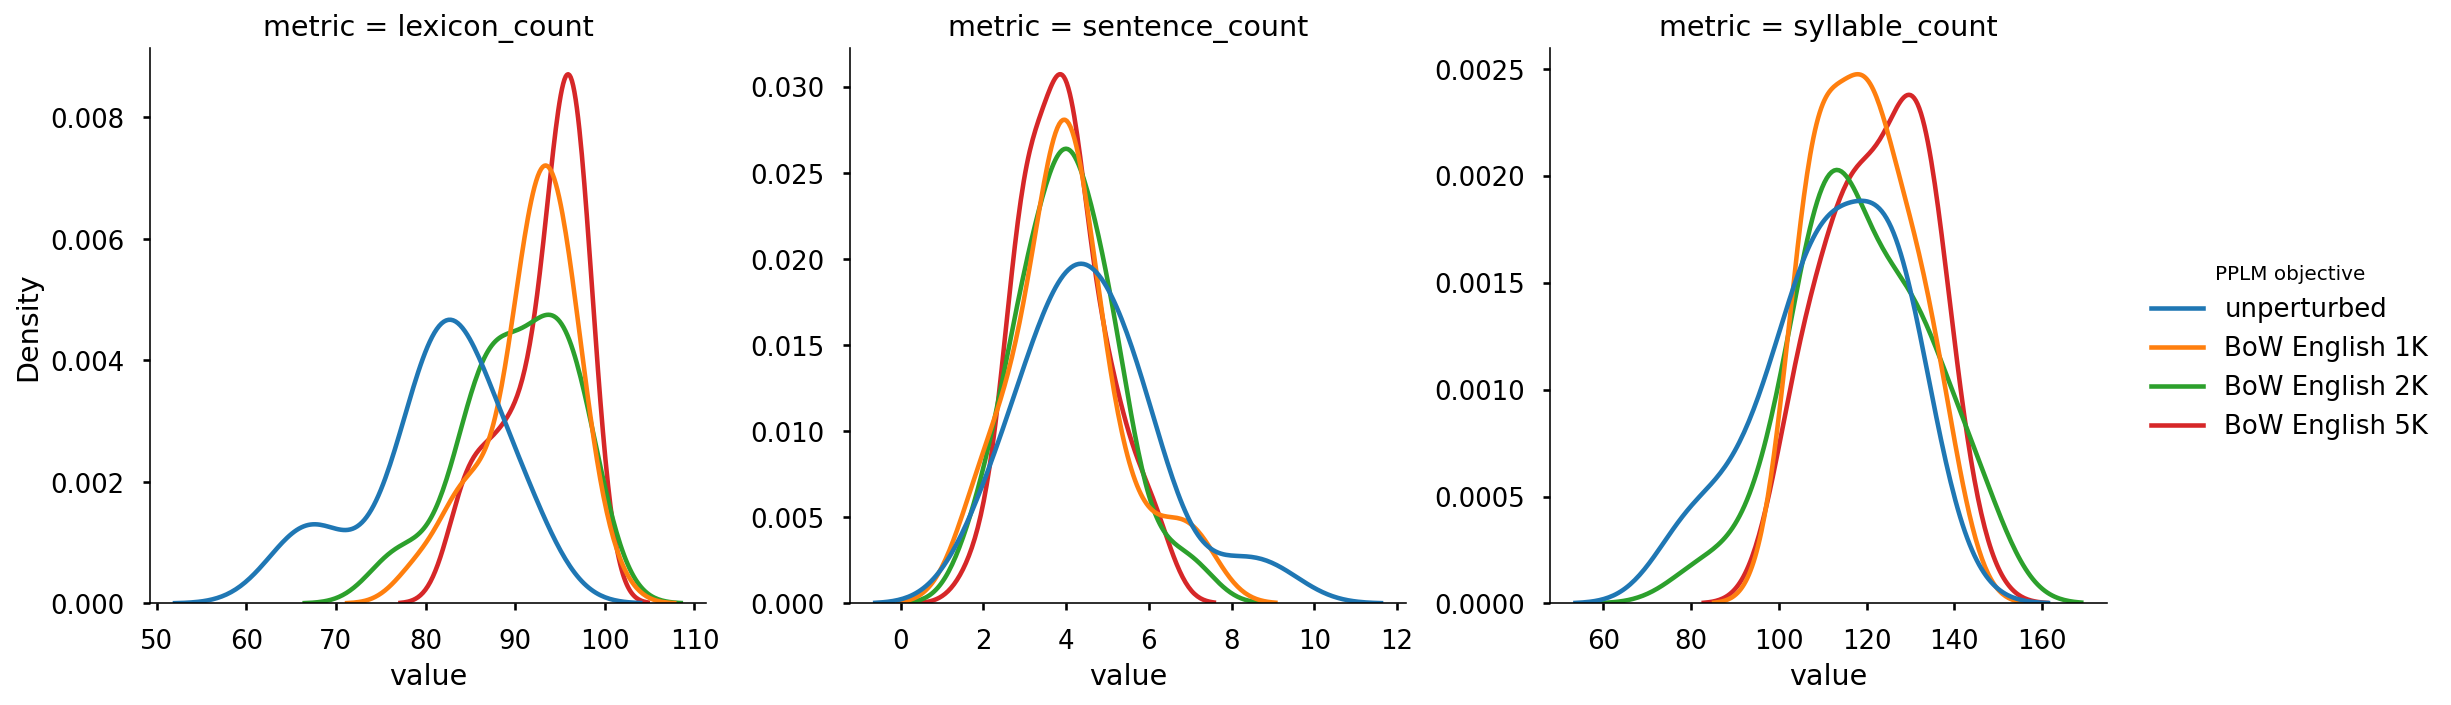

In [30]:
metrics = ['lexicon_count', 'sentence_count', 'syllable_count']
order = ['unperturbed', 'BoW English 1K', 'BoW English 2K', 'BoW English 5K']

# Display metrics summary
display(df_agg[metrics].loc[order].round(2))

# Plot distribution
data = df_combined[metrics + ['PPLM objective']]
data = data.melt(id_vars='PPLM objective', var_name='metric')
sns.displot(
    data=data,
    x="value",
    hue="PPLM objective",
    col="metric",
    kind="kde",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
);

### Vocabulary usage

Next, we look at the vocabulary: what fraction of the sampled words came from the BoW?

- All samples drawn with PPLM include a significantly higher portion of words from the word list. This confirms the effectiveness of PPLM as a mechanism to steer the generation.
- Across PPLM objectives (BoW of length 1K/2K/5K) we do not see a difference in how many words are included from the respective word lists.

,precision_english_1k,precision_english_2k,precision_english_5k
PPLM objective,,,
unperturbed,0.61,0.68,0.76
BoW English 1K,0.79,0.84,0.88
BoW English 2K,0.76,0.84,0.88
BoW English 5K,0.76,0.82,0.89


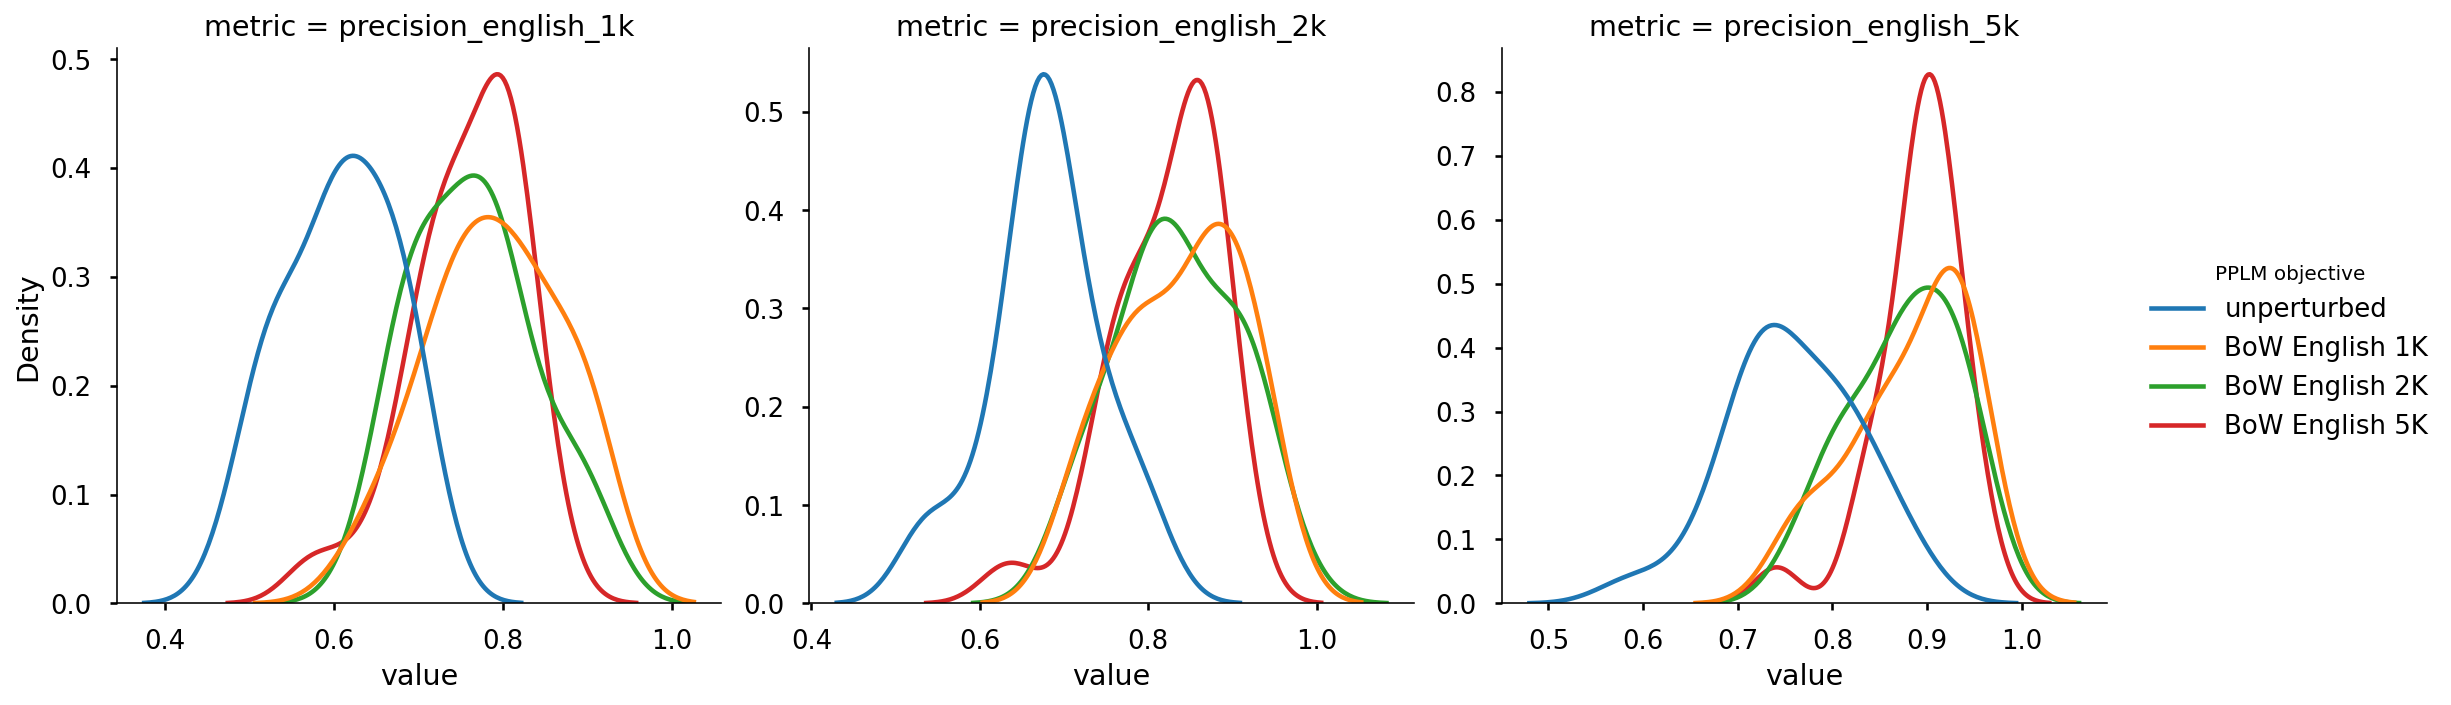

In [31]:
metrics = ['precision_english_1k', 'precision_english_2k', 'precision_english_5k']
order = ['unperturbed', 'BoW English 1K', 'BoW English 2K', 'BoW English 5K']

# Display metrics summary
display(df_agg[metrics].loc[order].round(2))

# Plot distribution
data = df_combined[metrics + ['PPLM objective']]
data = data.melt(id_vars='PPLM objective', var_name='metric')
sns.displot(
    data=data,
    x="value",
    hue="PPLM objective",
    col="metric",
    kind="kde",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
);

### Fluency and distinctiveness

- BoW samples have comparable fluency (ppl) and a consistent diversity (dist).

,ppl,dist
PPLM objective,,
unperturbed,33.18,0.82
BoW English 1K,23.76,0.84
BoW English 2K,29.63,0.84
BoW English 5K,26.05,0.84


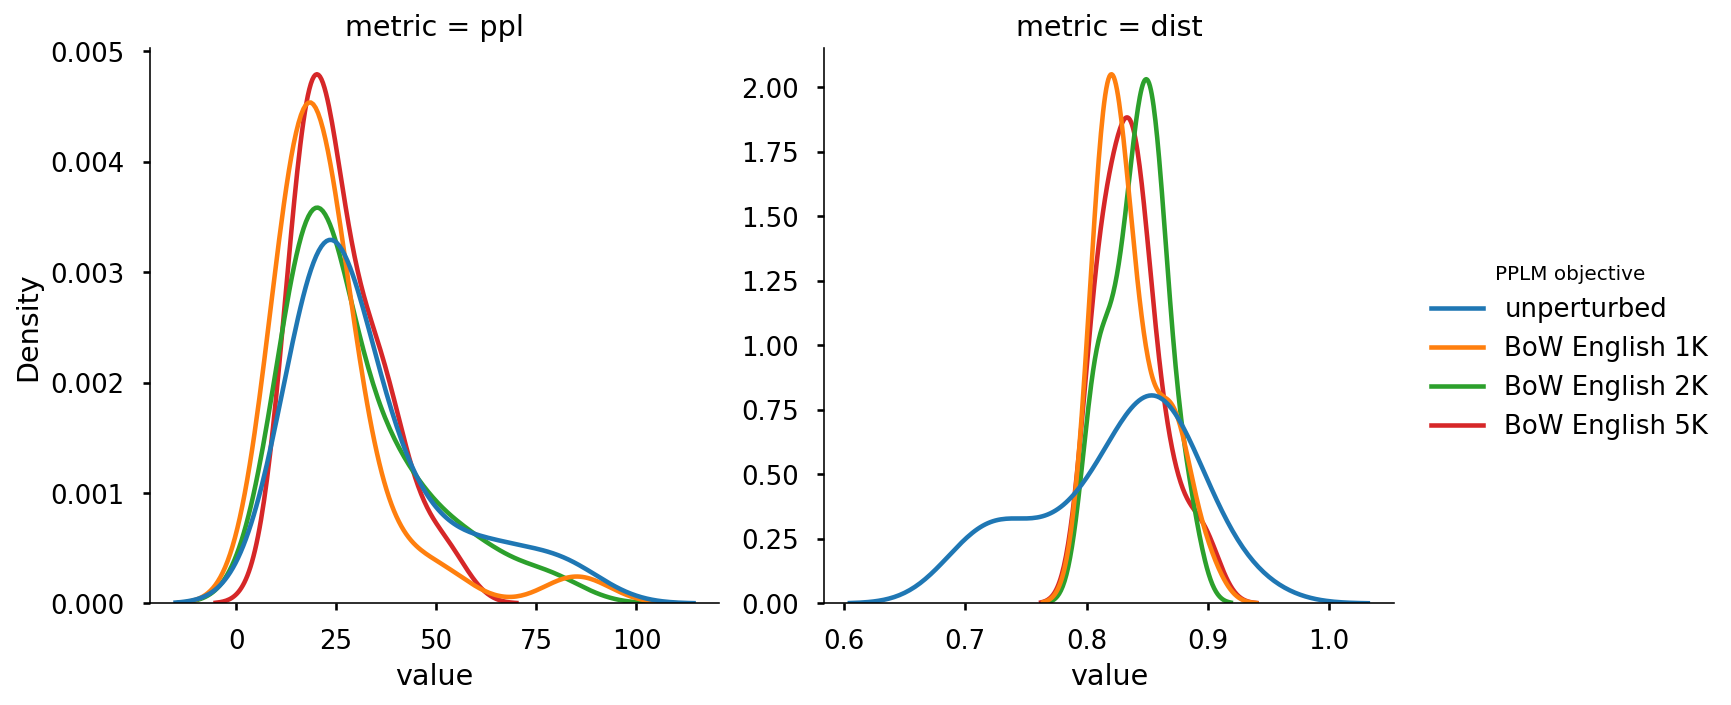

In [32]:
metrics = ['ppl', 'dist']
order = ['unperturbed', 'BoW English 1K', 'BoW English 2K', 'BoW English 5K']

# Display metrics summary
display(df_agg[metrics].loc[order].round(2))

# Plot distribution
data = df_combined[metrics + ['PPLM objective']]
data = data.melt(id_vars='PPLM objective', var_name='metric')
sns.displot(
    data=data,
    x="value",
    hue="PPLM objective",
    col="metric",
    kind="kde",
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
);

### Readability

We do not see a significant reduction in reading complexity when considering traditional readability measures.

> Interpretation
> - Flesch Reading Ease (↑): higher is better (easier to read)
> - Gunning Fog Index (↓): lower is better (easier to read)
> - Automated Readability Index (↓): lower is better (easier to read)
> - Coleman Liau Index (↓): lower is better (easier to read)

,flesch_reading_ease,gunning_fog,automated_readability_index,coleman_liau_index
PPLM objective,,,,
unperturbed,69.00,10.56,9.82,7.60
BoW English 1K,70.78,11.75,10.28,6.06
BoW English 2K,70.56,11.99,10.42,6.40
BoW English 5K,70.07,11.95,10.85,6.67


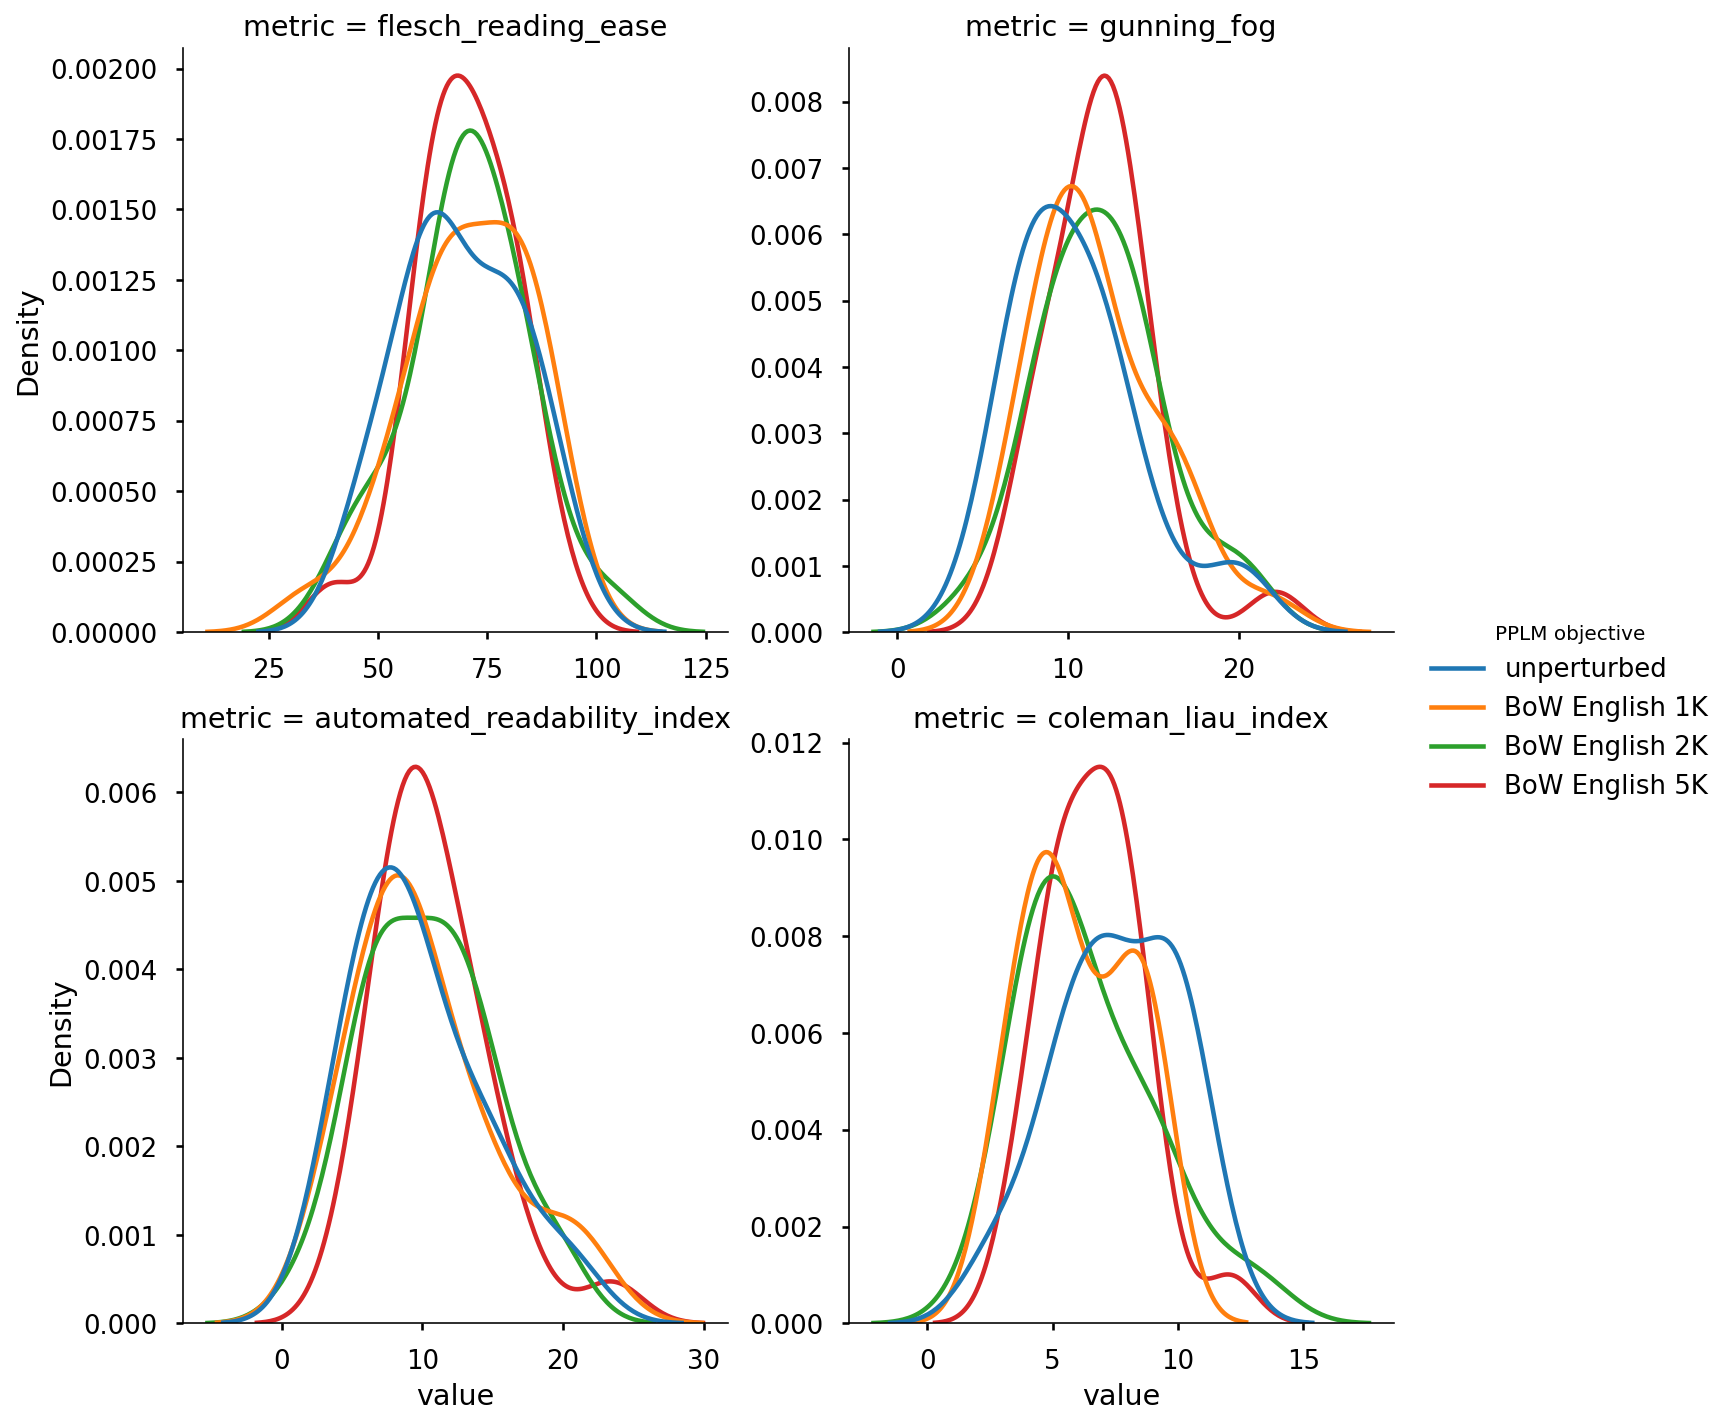

In [33]:
metrics = ['flesch_reading_ease', 'gunning_fog', 'automated_readability_index', 'coleman_liau_index']
order = ['unperturbed', 'BoW English 1K', 'BoW English 2K', 'BoW English 5K']

# Display metrics summary
display(df_agg[metrics].loc[order].round(2))

# Plot distribution
data = df_combined[metrics + ['PPLM objective']]
data = data.melt(id_vars='PPLM objective', var_name='metric')
sns.displot(
    data=data,
    x="value",
    hue="PPLM objective",
    col="metric",
    kind="kde",
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False)
);

### Blog Post Table

For inclusion in blog article.

In [34]:
metric_display_names = {
    'ppl': 'PPL',
    'dist': 'Dist.',
    'lexicon_count': 'Words',
    'precision_english_1k': 'Prec. 1K EN',
    'precision_english_2k': 'Prec. 2K EN',
    'precision_english_5k': 'Prec. 5K EN',
    'flesch_reading_ease': 'Flesch (↑)',
    'gunning_fog': 'Gunning-Fog (↓)',
    'automated_readability_index': 'ARI (↓)',
    'coleman_liau_index': 'Coleman-Liau (↓)',
}

rounding = {
    'ppl': 1,
    'dist': 2,
    'lexicon_count': 1,
    'precision_english_1k': 2,
    'precision_english_2k': 2,
    'precision_english_5k': 2,
    'flesch_reading_ease': 1,
    'gunning_fog': 1,
    'automated_readability_index': 1,
    'coleman_liau_index': 1,
}

df_display = df_agg[metric_display_names.keys()] \
    .loc[order] \
    .round(rounding) \
    .rename(metric_display_names, axis=1) \
    .rename({'unperturbed': 'Unguided'})

print(df_display.to_markdown())

| PPLM objective   |   PPL |   Dist. |   Words |   Prec. 1K EN |   Prec. 2K EN |   Prec. 5K EN |   Flesch (↑) |   Gunning-Fog (↓) |   ARI (↓) |   Coleman-Liau (↓) |
|:-----------------|------:|--------:|--------:|--------------:|--------------:|--------------:|-------------:|------------------:|----------:|-------------------:|
| Unguided         |  33.2 |    0.82 |    81   |          0.61 |          0.68 |          0.76 |         69   |              10.6 |       9.8 |                7.6 |
| BoW English 1K   |  23.8 |    0.84 |    91.7 |          0.79 |          0.84 |          0.88 |         70.8 |              11.7 |      10.3 |                6.1 |
| BoW English 2K   |  29.6 |    0.84 |    90.2 |          0.76 |          0.84 |          0.88 |         70.6 |              12   |      10.4 |                6.4 |
| BoW English 5K   |  26   |    0.84 |    93.2 |          0.76 |          0.82 |          0.89 |         70.1 |              12   |      10.8 |                6.7 |


### Blog Post Figure

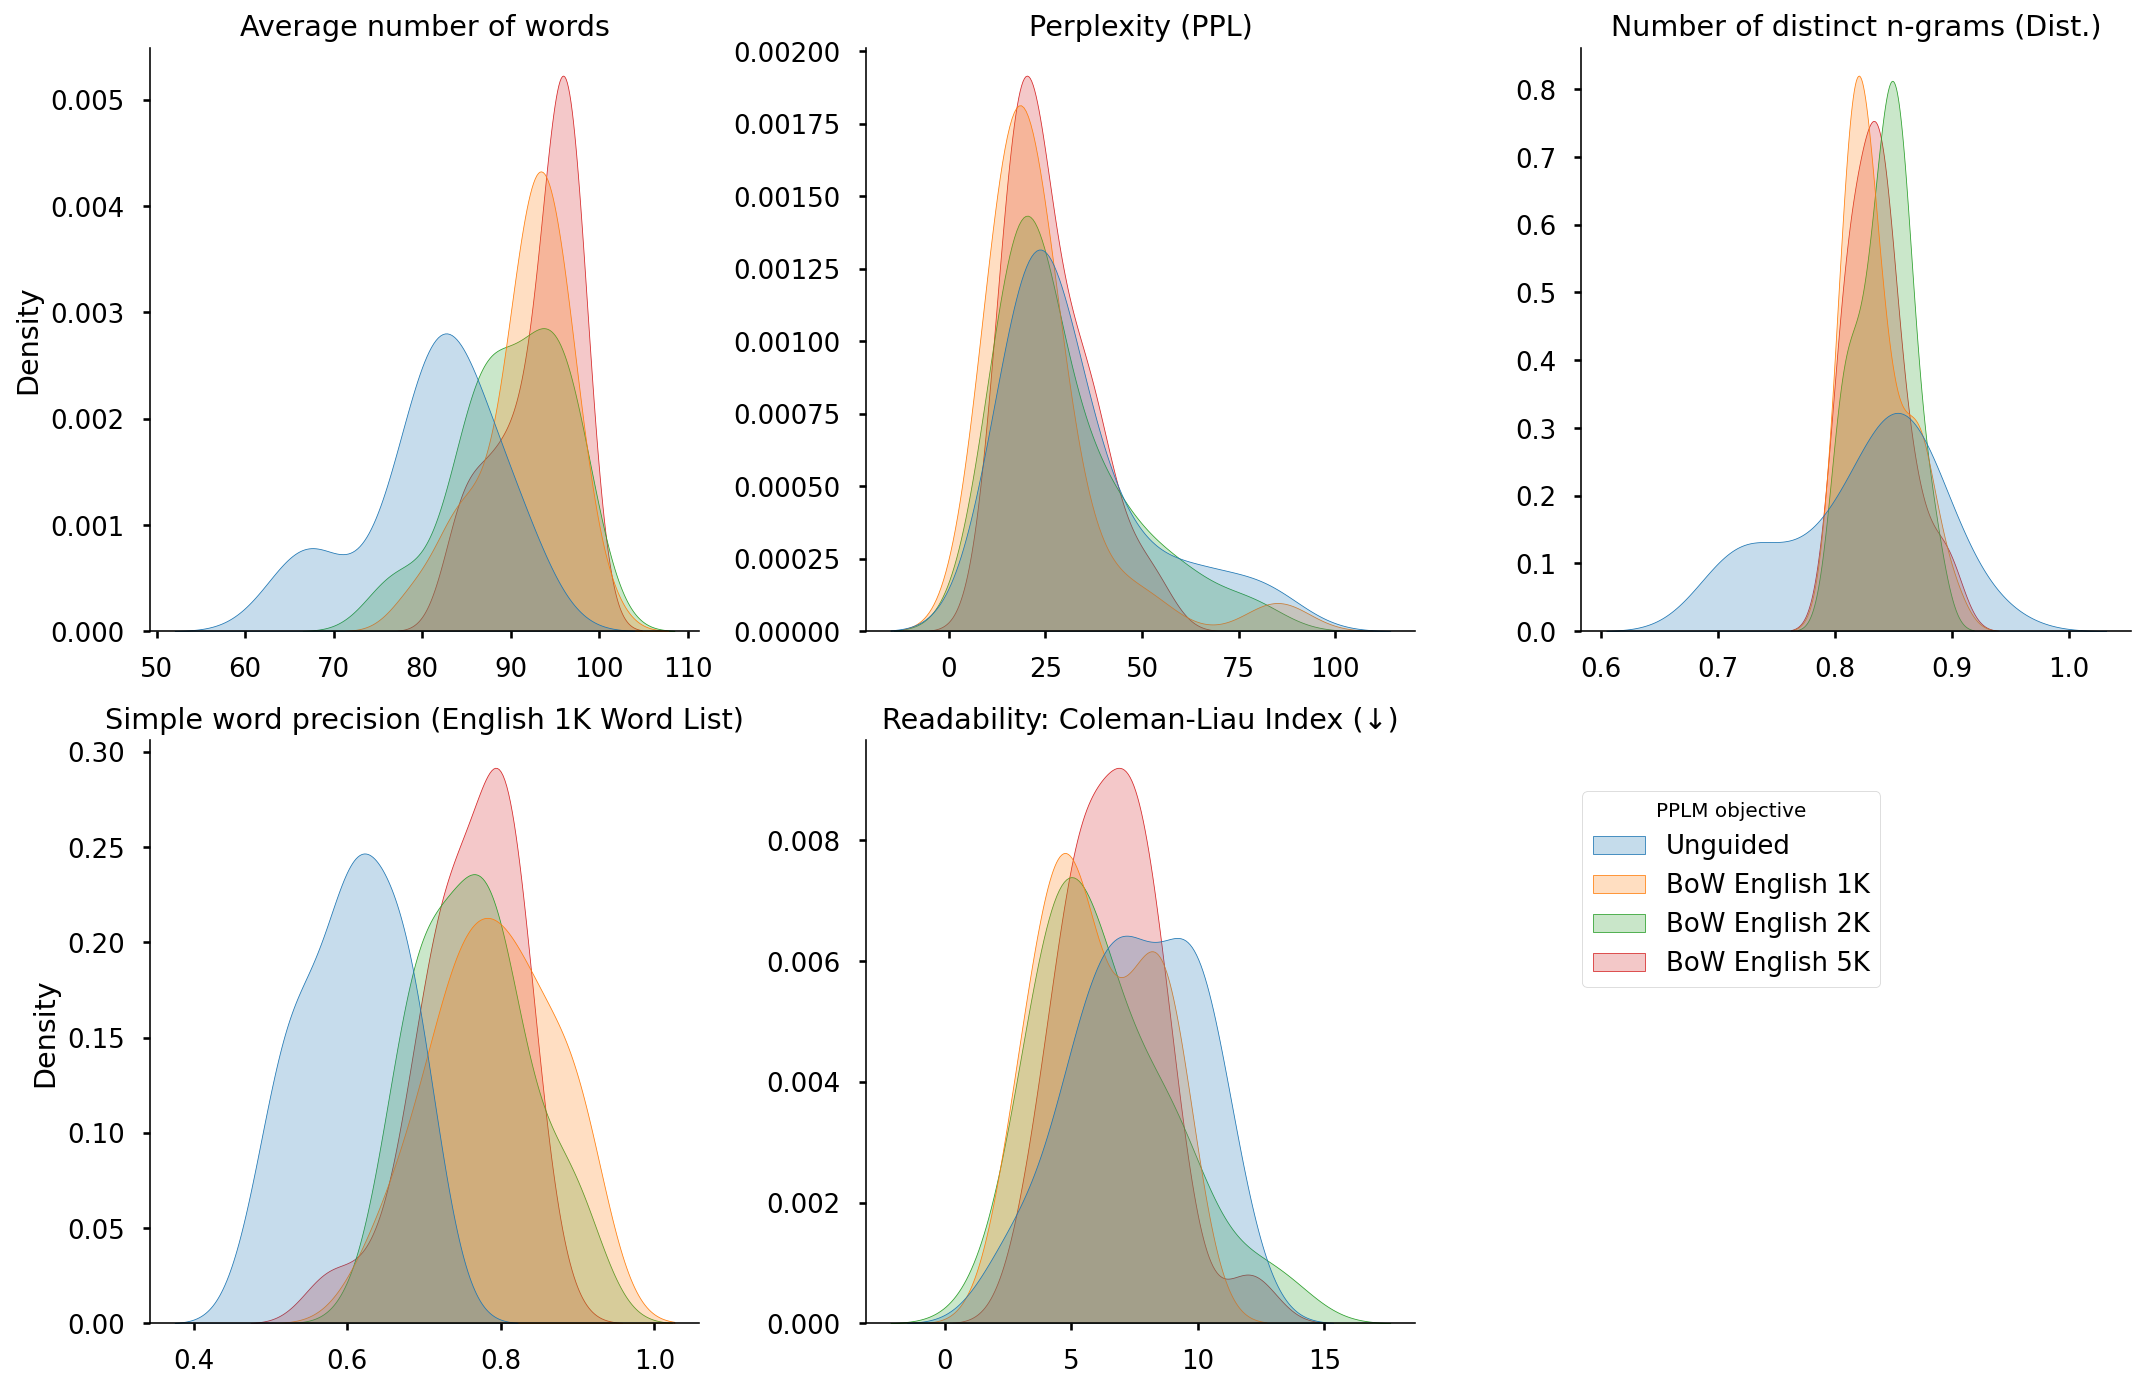

In [35]:
metrics = ['lexicon_count', 'ppl', 'dist', 'precision_english_1k', 'coleman_liau_index']

metric_display_names = {
    'ppl': 'Perplexity (PPL)',
    'dist': 'Number of distinct n-grams (Dist.)',
    'lexicon_count': 'Average number of words',
    'precision_english_1k': 'Simple word precision (English 1K Word List)',
    'coleman_liau_index': 'Readability: Coleman-Liau Index (↓)',
}

# Plot distribution
data = df_combined[metrics + ['PPLM objective']]
data = data.rename(metric_display_names, axis=1)
data['PPLM objective'] = data['PPLM objective'].replace({'unperturbed': 'Unguided'})
data = data.melt(id_vars='PPLM objective', var_name='metric')
g = sns.displot(
    data=data,
    x="value",
    hue="PPLM objective",
    col="metric",
    kind="kde",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False, legend_out=False),
    fill=True
);
g.set_titles(col_template="{col_name}")
g.set(xlabel=None)
sns.move_legend(g, bbox_to_anchor=(0.73,0.3), loc="lower left")

plt.savefig('imgs/readability-metrics.svg')

### Qualitative analysis

In [36]:
from run_pplm import get_bag_of_words_indices

def color_string(text, bag_of_words, included=True, tokenizer=PPLM_TOKENIZER):
    bow_word_ids = set()
    
    bow_indices = get_bag_of_words_indices(bag_of_words, tokenizer)
    for single_bow_list in bow_indices:
        # filtering all words in the list composed of more than 1 token
        filtered = list(filter(lambda x: len(x) <= 1, single_bow_list))
        # w[0] because we are sure w has only 1 item because previous fitler
        bow_word_ids.update(w[0] for w in filtered)

    
    tokens = tokenizer.encode(text)
    for i, pert_gen_tok_text in enumerate(tokens):
        colored_text = ''
        for word_id in tokens:
            if included:
                highlight = word_id in bow_word_ids
            else:
                highlight = word_id not in bow_word_ids
            
            if highlight:
                colored_text += '{}{}{}'.format(
                    '<span style="color: red">',
                    tokenizer.decode([word_id]),
                    '</span>'
                )
            else:
                colored_text += tokenizer.decode([word_id])
                
    return colored_text

print(color_string('This is a test remarkable', ['english-1k']))

This<span style="color: red"> is</span><span style="color: red"> a</span><span style="color: red"> test</span> remarkable


First, pivot the text (rows prompts, columns are PPLM flavors). Then, color each generated sample. <font color=red>Red = word is not in the English 5K BoW</font>

In [37]:
df = df_combined[['text', 'PPLM objective', 'prompt']] \
    .pivot(index='prompt', columns=['PPLM objective'], values='text')

df['unperturbed'] = df['unperturbed'].apply(lambda s: color_string(s, ['english-5k'], included=False))
df['BoW English 1K'] = df['BoW English 1K'].apply(lambda s: color_string(s, ['english-5k'], included=False))
df['BoW English 2K'] = df['BoW English 2K'].apply(lambda s: color_string(s, ['english-5k'], included=False))
df['BoW English 5K'] = df['BoW English 5K'].apply(lambda s: color_string(s, ['english-5k'], included=False))

In [40]:
df = df.rename({'unperturbed': 'Unguided'}, axis=1)

order = ['Unguided', 'BoW English 1K', 'BoW English 2K', 'BoW English 5K']

In [41]:
good_examples = [
    "A pulmonary edema is",
    "A radiograph is",
    "Gravity is",
    "The football",
    "The ozone layer is",
    "Vitamine D is",
]

bad_examples = [
    "A car is",
    "A rope is",
    "The pizza",
    "The potato",
]

others = set(df_combined['prompt'].unique()) - set(good_examples) - set(bad_examples)

#### Good examples

- More common words are used in the PPLM BoW samples.
- Also PPLM seems to prevent the generation of many entities (c.f. `The football`)

In [42]:
display(HTML(df.loc[good_examples][order].to_html(escape=False)))

PPLM objective,Unguided,BoW English 1K,BoW English 2K,BoW English 5K
prompt,,,,
A pulmonary edema is,"A pulmonary edema is a condition where your lungs become congested, inflamed, or blocked. You may feel tired and weak from the pain. Pulmonary edema is common when you have heart disease, lung disease, high blood pressure, or high cholesterol or blood sugar levels. You may experience a cough or other symptoms of asthma (shortness of breath).I have been working for a company called Cogent Systems for a while now and was able to get into the development of a","A pulmonary edema is a serious problem of the lung. The pulmonary edema is caused by the presence of gas or a thickening of the lungs. It can happen at any time and in various ways. The reason why a problem of the lungs is not a major problem is because it can be prevented by following these simple rules: 1. Do not get too much air. The more the lungs are filled with air, the better the lung health. 2. Don't use the inhaler too quickly","A pulmonary edema is a sign of a serious condition. It is usually caused by a blood problem, a disease or other problem in the body, including an infection.A new report has warned of the dangers that lie in our relationship with food. The study, from the World Health Organization, looked at health and nutrition trends worldwide in the past 50 years and found that in the past 50 years, obesity has increased. It's the leading cause of death for the under-fives in the world. It",A pulmonary edema is a serious condition that can occur when a person who has an infection or an underlying illness gets too sick to stand up straight. When this occurs people who have had to stand up for hours can experience a sudden and severe loss of feeling in the legs and feet. It is very rare for a person to have a severe pulmonary edema and if they do then it is very likely to be temporary. A person should call 111 if they feel that they have a serious medical condition and their condition is
A radiograph is,"A radiograph is a picture taken of a patient. An xray is a picture taken of the body. An MR scanner is a machine that uses electromagnetic radiation for imaging purposes. The term radiology refers to any of these. An MRI, or magnetic resonance imaging (MRI), is a diagnostic method used to determine whether a part of the body is affected by injury. The term radiograph can be used to describe a radiographic image taken from the MRI. There are","A radiograph is a picture taken by an instrument that shows the changes in the way your body works as a result of a single, specific action, such as eating a meal. The picture is called an image because of its ability to show a person's appearance, which changes as you eat the food, but can be a picture as well as a person.This is a conversation between A little girl in a red dress and a black man in black and white pants. A little girl in a red dress","A radiograph is a medical image that shows a part of the body that's being examined by a medical professional. The image is taken with a digital camera and the person's face is shown in the image. An image is a small file on a computer, disk, or other media. It is usually in a file format such as a picture or a video file. In an image, people can put their face in various places, such as their eyes, or in a different area of the body, like",A radiograph is a picture taken by an instrument that shows the changes in the way the body works as a result of changes in the environment. It can help you determine the cause of a health problem or condition by looking at the way the body works and what the changes are doing to it. In radiography a patient's body can be seen from a number of different locations. A radiograph is usually done by a doctor who has a background in medical imaging. It is done at a particular time and place for the
Gravity is,"Gravity is a concept that has long captivated the human mind, with its seemingly infinite possibilities of destruction, change an

#### Bad Examples

Here we see that both the unperturbed and perturbed examples include a relatively high portion of words not in the BoW. Also the texts are not easier to read.

In [43]:
display(HTML(df.loc[bad_examples][order].to_html(escape=False)))

PPLM objective,Unguided,BoW English 1K,BoW English 2K,BoW English 5K
prompt,,,,
A car is,"A car is driven through a traffic island at a busy crossroads in Tokyo, Japan. Tokyo's traffic islands are often a place to see traffic jams. But one of Tokyo's busiest crossroads, the Tokyo Sky Tree, was recently covered by a giant truck, apparently as a protest over what it sees as an unfair and outdated system. The car that was driving around at the intersection of the Sky Tree with the Yamanote Bridge was covered by a gigantic truck, as a protest over","A car is seen in this picture taken on March 8, 2013, in the southern German city of Munich after the driver crashed into a police van in the city's busy Trenitalia street. REUTERS/Michaela Rehle German police said they believe the suspect in Saturday night's deadly crash in Trenitalia was wearing a bulletproof vest in the attack. ""A car was involved in a collision with a police van that caused the death of a man who was a passenger,""","A car is seen on the highway during a morning rush hour in Shanghai, China, on March 9. Photo: Reuters By Peter Tamblyn and David Shepardson CHINA is a nation of many roads and the traffic that is seen is of different sorts, each with its own distinctive and distinctive character – and each one has an impact on the people around them and on their lives. For example, in the north of China, you will find that most cities and villages are","A car is seen on the highway during the morning rush hour in Shanghai on July 8. (Photo: Xinhua) Story Highlights The new car will be sold through a partnership to a Shanghai auto maker. An estimated 1 million people drive to work to buy cars, and Shanghai's transportation system is one of the world's busiest in terms of traffic. A new car will be sold on a partnership basis to a Shanghai auto maker, according to a report by China's state-run Xinhua newspaper"
A rope is,"A rope is a device which is attached at a fixed point to a rope or other object. It is used for tying together ropes which are not made of wood. Rope is a type of chain, rope is a type of chain. A knot on the rope is a chain which is attached at a fixed point to a chain. Knots are usually made of two loops of the same material, one of which may not have a knot or be fixed at the same place as the other.","A rope is a type of long chain used to tie the ends of a pair of clothing together. Rope-making is a form of rope-making, and is the art of making a rope out of different lengths of cloth with a combination of two or more materials. It has to do with the way the cloth is woven, or woven with different materials and in different ways, with a single piece of cloth. It is also the craft that is the focus of a number of the most popular art",A rope is not an actual word for a man's head. It is a term used by men who have lost their manhood to a new and better woman. They are called 'Rope men'.(written from a Production point of view Real World article Tuvok and a crew of crew of crew of the USS Voyager are searching for a planet on the far side of a star. Contents show] Summary Edit Teaser Edit Tuvok is on,A rope is a way to hold a piece of string and make it longer and more secure than a regular piece of rope. It's a better solution for the most basic situations when you just want the string to stay in place and not be broken when you want to get away or when you're just trying to get out of an awkward situation or get out of an awkward situation quickly. Rigging is one of the simplest things you can do that can help your game go from a simple idea to one
The pizza,"The pizza was amazing. I love pizza. I love pizza, but I love my own pizza. This pizza was awesome and I'm not sure that I've ever had better pizza than this. It wasn't that great, but still, it was good. I would definitely recommend this to others. My boyfriend and I were looking for some pizza on a Sunday night and decided to try this place after our other local pizzeria closed. We were gr

#### Remaining examples

In [44]:
display(HTML(df.loc[others][order].head(2).to_html(escape=False)))

PPLM objective,Unguided,BoW English 1K,BoW English 2K,BoW English 5K
prompt,,,,
The steam engine is,"The steam engine is a steam engine of the type used for making gas, but with a much higher efficiency. It's also very efficient compared to other types that have to be built with steam or coal, such as the steam engine that powered the steam locomotive. The steam generator is a boiler or gas turbine used to power a steam engine, although it may be much faster. It also has a much higher efficiency than the coal generator, and is used to heat the fuel, as well as powering","The steam engine is not only a great place to find your next job, but also a great way to help to reduce the overall carbon emissions that we generate. A large proportion of the energy that is generated from the burning of fossil fuels is used to drive the engine, as well as to heat and cool the buildings, and all of the buildings. In fact, we are now using the entire amount of power generated by our engines in order to run all the power plants and other facilities in this country. The average person","The steam engine is one of the most important parts of any modern car. If you have the money to spend on buying one, then there's no way you can miss out on the other benefits of the new technology that is going to replace them. If you haven't heard of it yet, the Steam Engine is the world's most powerful and fastest motor ever made. It's also one of the most expensive cars to buy and it has the most expensive price tag of any modern car. But what if you","The steam engine is one of the oldest and one of the most powerful devices in human history. It is used in almost all industries, from mining to manufacturing to transport and many more. The engine is capable of generating a constant amount of steam and it has been used for millions of years to generate electricity, heat and light in most of the world. What is the difference between the steam engine and other power source? There are a lot of different power source available today. In the last decade or so"
Convex optimization is,"Convex optimization is a method of calculating a linear combination of two values, called a convexity of the input function and its output function. For example, let's say that for a 2D function x: y: z that takes 2 values x and y, and the input is 2 functions x and y, and the output function is 2 functions z and x: y: z, then there are 2 functions x and y in the output function, and each of these functions has 2 inputs, which is a","Convex optimization is a way to create a smooth and clean rendering. It's similar to how a smooth screen looks when the image is rendered, with an even look and feel. In this case, the image will also look more natural. The image you see below is the result of my process, where I have added an ""X"" to each of the four ""X""s to make my images. I have also added the ""Z"" and the ""A"" to make the image a little more","Convex optimization is the ability to get a very good result at high cost without any effort. A great example of a convex optimization is a method I call ""Coffin"" or ""Cobblestone."" I like to use this method on the front-end of a website, where there are a lot of small elements. A very simple example is a simple table that shows all the prices for a product at any given time. I will put a text field at the front end, and a","Convex optimization is a technique that can make your computer more efficient at processing data. When you have a large set of data in one place, it will be difficult to process it all at once. This can cause your computer to perform badly and slow down the rest of the computer and cause it to become less efficient. This can also lead to a loss of data from the computer when you need to perform certain tasks, such as opening and closing files, or when you do things that are not part of the normal process"
